In [5]:
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")
small_llm = ChatOpenAI(model_name="gpt-4o-mini")


In [7]:
from langchain_core.tools import tool

# Required: tool decorator, expected arguments, description
@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다"""
    return a * b

In [8]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

# search_tool.invoke("Obama's first name ?")

In [9]:
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)
from langchain_google_community.gmail.toolkit import GmailToolkit

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
# 1. Google credential 받기
# 2. Gmail API 활성화하기
credentials = get_gmail_credentials(
    token_file="./google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/client_secret_956757050949-dh18vafkhg3aqmq0tigt1es79q2qisb6.apps.googleusercontent.com.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x7f7758945d30>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7f7758945d30>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x7f7758945d30>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7f7758945d30>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x7f7758945d30>)]

In [10]:
from langchain.agents import load_tools

loaded_tools_list = load_tools(["arxiv"])

In [11]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_chroma import Chroma

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

# text_path = "./docs/real_estate_tax.txt"
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = 1500,
#     chunk_overlap = 100,
#     separators=['\n\n', '\n']
# )
# loader = TextLoader(text_path)
# document_list = loader.load_and_split(text_splitter)

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding_function,
#     collection_name = 'real_estate_tax',
#     persist_directory = './real_estate_tax_collection'
# )

vector_store = Chroma(
    collection_name="real_estate_tax",
    embedding_function=embedding_function,
    persist_directory="./real_estate_tax_collection",
)

retriever = vector_store.as_retriever()
retriever_tool = create_retriever_tool(retriever, "retriever", "Contains information about real estate tax up to December 2024")

In [12]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tools_list
llm_with_tools = small_llm.bind_tools(tool_list)
# AnyMessage(System, Human, AI, Tool) 리스트를 입력으로 받아야한다.
# 마지막은 AI message 이어야하고, 해당 메시지에 tool_calls가 있어야한다.
tool_node = ToolNode(tool_list)

In [79]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str
    
graph_builder = StateGraph(AgentState)


In [80]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):
    messages = state["messages"]
    # message는 전체 history.. token이 녹는다 => 비용/시간이 올라간다 => 서비스 품질 저하로 이어진다.
    # message 정리 방법
    ## 1. 삭제, 예를들어 초기 문맥은 필요없을 수 있다. (하지만 관련성이 없지 연관성이 없지는 않을 수 있다. )
    ## 2. 요약
    summary = state["summary"]
    if summary != '':
        messages = [SystemMessage(content="Here is the summary of earlier conversation: {summary}")] + messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [81]:
from typing import Literal
from langgraph.types import Command, interrupt

def human_review(state: AgentState) -> Command[Literal["tools"]]: # tools와 연결하는 방법 No Edge
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({"question": "이렇게 진행하면 될까요?", "tool_call": tool_call})
    # 1. LLM이 결정을 잘했는지
    # 2. 도구를 사용할 때, 잘 골랐는지 혹은 args가 잘 못 됐는지
    # 3. 도구 자체가 잘 못 선택되었을 때
    review_action = human_review["action"]
    review_data = human_review.get("data") # 도구 호출의 args
     
    if review_action == "continue":
        return Command(goto="tools")
    
    elif review_action == "update_args":
        updated_ai_message = {
            "id": last_message.id, # 수정하려는 메시지의 id 삽입 필요
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [{ # (tool).tool_calls 했을 때 나오는 arguments
                "id": tool_call["id"],
                "name": tool_call["name"],
                "args": review_data
            }]
        }
        
        return Command(goto="tools", messages={"messages": updated_ai_message})

In [82]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    messages = state["messages"]
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {"messages": delete_messages}

In [83]:
def summarize_messages(state: AgentState):
    messages = state["messages"]
    summary = state["summary"]
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations\n",
        chat_history:{messages}\n",
        summary:{summary}'''
    
    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {"summary": response.content}

In [84]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return "human_review"
    
    return "summarize_messages"

In [85]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node('human_review', human_review)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [86]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges("agent", should_continue, ["human_review", 'summarize_messages'])
# graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("summarize_messages", "delete_messages")
graph_builder.add_edge("delete_messages", END)


In [87]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

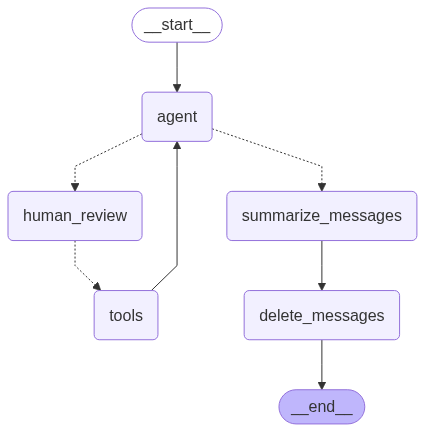

In [57]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

# LLM이 잘 됐다고 생각하면 Continue

In [64]:
from langchain_core.messages import HumanMessage

config = {
    "configurable": {
        "thread_id": "summarize_paper"
    }
}

# Possible to interaction with agent !
query = "Attention Is All You Need 논문의 내용을 검색해서 요약해주세요"
for chunk in graph.stream({"messages": [HumanMessage(content=query)], "summary": ""}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Attention Is All You Need 논문의 내용을 검색해서 요약해주세요


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_jIDSka2Zx0ymJ3AHvZ7xUzfP", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}

In [24]:
graph.get_state(config).values["messages"]

[HumanMessage(content='Attention Is All You Need 논문의 내용을 검색해서 요약해주세요', additional_kwargs={}, response_metadata={}, id='0e9d940a-e5d7-4c4f-b0d6-86a5874df353'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Nsi1PDGENwaSU1O9nPw7p3NE', 'function': {'arguments': '{"query":"Attention Is All You Need"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 744, 'total_tokens': 762, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3at40GUn4j4mUl874xaBHoh3pLsh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6f9de9d-b3e9-48e3-8232-93a0f06d01fc-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Attenti

In [25]:
graph.get_state(config).next

('human_review',)

In [63]:
for chunk in graph.stream(
    Command(resume={"action": "continue"}),
    config=config,
    stream_mode="updates",
):
    print(chunk)

TypeError: Command.__init__() got an unexpected keyword argument 'messages'

# LLM의 도구 호출 수정

In [88]:
from langchain_core.messages import HumanMessage

config = {
    "configurable": {
        "thread_id": "summarize_paper"
    }
}

# 실제 논문 이름은 Large Language Models: A Survey
query = "LLM Survey 논문의 내용을 검색해서 요약해주세요"
for chunk in graph.stream({"messages": [HumanMessage(content=query)], "summary": ""}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_EDvWdoEyPs9qynthtxprOQdh)
 Call ID: call_EDvWdoEyPs9qynthtxprOQdh
  Args:
    query: LLM Survey


In [89]:
graph.get_state(config).values["messages"]

[HumanMessage(content='LLM Survey 논문의 내용을 검색해서 요약해주세요', additional_kwargs={}, response_metadata={}, id='81d1fce9-bffb-4fe4-b148-e5424591ced6'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EDvWdoEyPs9qynthtxprOQdh', 'function': {'arguments': '{"query":"LLM Survey"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 742, 'total_tokens': 758, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3bhHfIjaoBZOgKR0LavRdduCsFdL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e844f2ff-0d25-452a-bad7-a03cbbf48aa1-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LLM Survey'}, 'id': 'call_EDvWdoEyPs9

In [76]:
graph.get_state(config).next

('human_review',)

In [ ]:
for chunk in graph.stream(
    Command(resume={"action": "update_args", "data": {"query": "Large Language Models: A Survey"}}),
    config=config, stream_mode="updates"
):
    print(chunk)
                          

TypeError: Command.__init__() got an unexpected keyword argument 'messages'